In [1]:
using PyPlot

In [2]:
const Δt    = 0.1;
const ntime = 10000;
const t0    = 0.;
const x0    = [acos(0.4), 0.0];

In [3]:
function benchmark(f_int, Δt, ntime, nloop=5, print_stat=true)
    
    f_int(Δt, ntime)
    
    mem = [@allocated f_int(Δt, ntime) for i=1:nloop ]
    t   = [@elapsed   f_int(Δt, ntime) for i=1:nloop ]
    
    if print_stat
        println("Number of loops: ", nloop)
        println("Elapsed time:    ", sum(t))
        println("Minimum time:    ", minimum(t))
        println("Maximum time:    ", maximum(t))
        println("Average time:    ", mean(t))
        println("Median  time:    ", median(t))
        println("Minimum Alloc:   ", minimum(mem))
        println("Maximum Alloc:   ", maximum(mem))
        println("Average Alloc:   ", div(sum(mem), nloop))
    end

    return t, mem
end

benchmark (generic function with 3 methods)

In [4]:
function plot_solution(x, y)
    fig = figure(figsize=(6,6))
    plot(x, y)
    xlim(0, 6)
    ylim(-2,+2)
end

plot_solution (generic function with 1 method)

#### GeomDAE.jl

In [5]:
using GeomDAE

In [6]:
function f_geomdae(t, x, fx)
    fx[1] = x[2]
    fx[2] = sin(x[1])
end

f_geomdae (generic function with 1 method)

In [7]:
function run_pendulum_geomdae(Δt=Δt, ntime=ntime)
    integrate(f_geomdae, x0, getTableauERK4(), Δt, ntime; t₀=t0)
end

run_pendulum_geomdae (generic function with 3 methods)

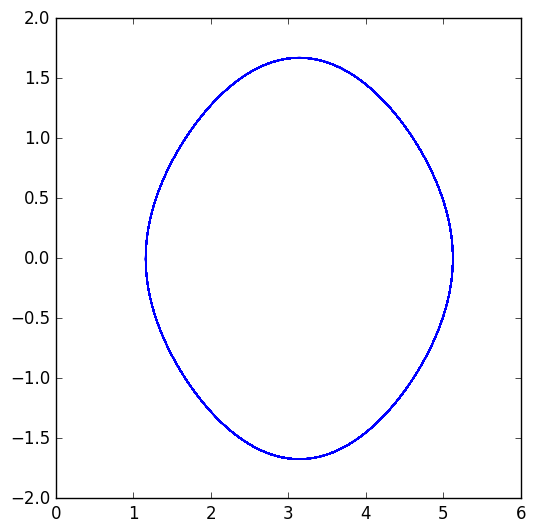

(-2,2)

In [8]:
sol = run_pendulum_geomdae()
plot_solution(sol.x[1,:], sol.x[2,:])

In [9]:
benchmark(run_pendulum_geomdae, Δt, ntime)

Number of loops: 5
Elapsed time:    0.01363286
Minimum time:    0.002697911
Maximum time:    0.002752718
Average time:    0.002726572
Median  time:    0.002723609
Minimum Alloc:   242752
Maximum Alloc:   242752
Average Alloc:   242752


([0.00272361,0.00269791,0.00275272,0.0027223,0.00273633],[242752,242752,242752,242752,242752])

#### ODE.jl

In [10]:
using ODE

In [11]:
function f_ode(t, x)
    [x[2],  sin(x[1])]
end

f_ode (generic function with 1 method)

In [12]:
function run_pendulum_ode(Δt=Δt, ntime=ntime)
    ode4(f_ode, x0, [t0:Δt:Δt*ntime;])
end

run_pendulum_ode (generic function with 3 methods)

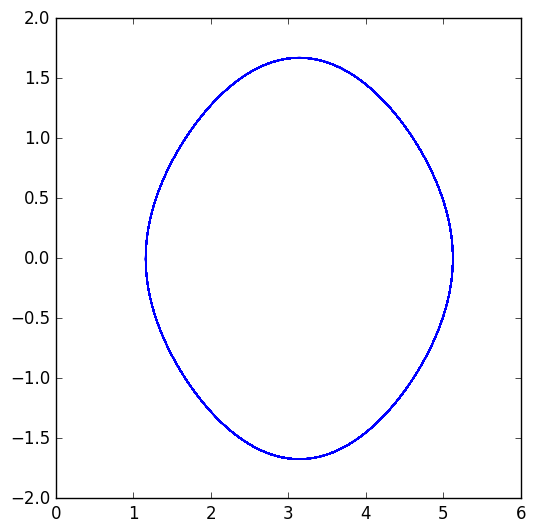

(-2,2)

In [13]:
t, y = run_pendulum_ode()
x = hcat(y...)'
plot_solution(x[:,1], x[:,2])

In [14]:
benchmark(run_pendulum_ode, Δt, ntime)

Number of loops: 5
Elapsed time:    0.141517207
Minimum time:    0.025426912
Maximum time:    0.033087016
Average time:    0.0283034414
Median  time:    0.027716994
Minimum Alloc:   17345184
Maximum Alloc:   17345184
Average Alloc:   17345184


([0.027717,0.027795,0.033087,0.0254269,0.0274913],[17345184,17345184,17345184,17345184,17345184])

#### DifferentialEquations.jl

In [15]:
using DifferentialEquations

In [16]:
function f_de(t, x)
    [x[2],  sin(x[1])]
end

f_de (generic function with 1 method)

In [17]:
function run_pendulum_de(Δt=Δt, ntime=ntime)
    solve(ODEProblem(f_de, x0, (t0, Δt*ntime)), RK4(), dt=Δt, dense=false, adaptive=false)
end

run_pendulum_de (generic function with 3 methods)

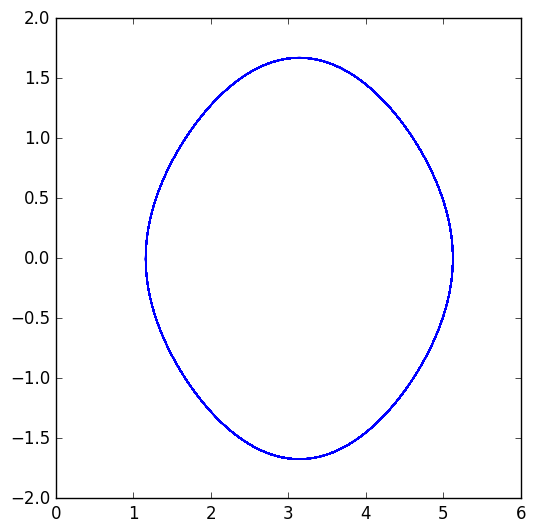

(-2,2)

In [18]:
sol = run_pendulum_de()
x   = hcat(sol.u...)'
plot_solution(x[:,1], x[:,2])

In [19]:
benchmark(run_pendulum_de, Δt, ntime)

Number of loops: 5
Elapsed time:    0.082063671
Minimum time:    0.014840623
Maximum time:    0.01757954
Average time:    0.0164127342
Median  time:    0.016669088
Minimum Alloc:   13783168
Maximum Alloc:   13783168
Average Alloc:   13783168


([0.0161423,0.0175795,0.0148406,0.0166691,0.0168321],[13783168,13783168,13783168,13783168,13783168])

#### Comparison

In [20]:
const ntimes = [100, 1000, 10000, 100000, 1000000];
const nloop  = 10

10

In [21]:
geomdae_tel = zeros(Float64, ntimes)
geomdae_mem = zeros(Float64, ntimes)

for i in 1:length(ntimes)
    tel, mem = benchmark(run_pendulum_geomdae, Δt, ntimes[i], nloop, false)
    geomdae_tel[i] = median(tel)
    geomdae_mem[i] = div(sum(mem), nloop)
end

In [22]:
ode_tel = zeros(Float64, ntimes)
ode_mem = zeros(Float64, ntimes)

for i in 1:length(ntimes)
    tel, mem = benchmark(run_pendulum_ode, Δt, ntimes[i], nloop, false)
    ode_tel[i] = median(tel)
    ode_mem[i] = div(sum(mem), nloop)
end

In [23]:
de_tel = zeros(Float64, ntimes)
de_mem = zeros(Float64, ntimes)

for i in 1:length(ntimes)
    tel, mem = benchmark(run_pendulum_de, Δt, ntimes[i], nloop, false)
    de_tel[i] = median(tel)
    de_mem[i] = div(sum(mem), nloop)
end

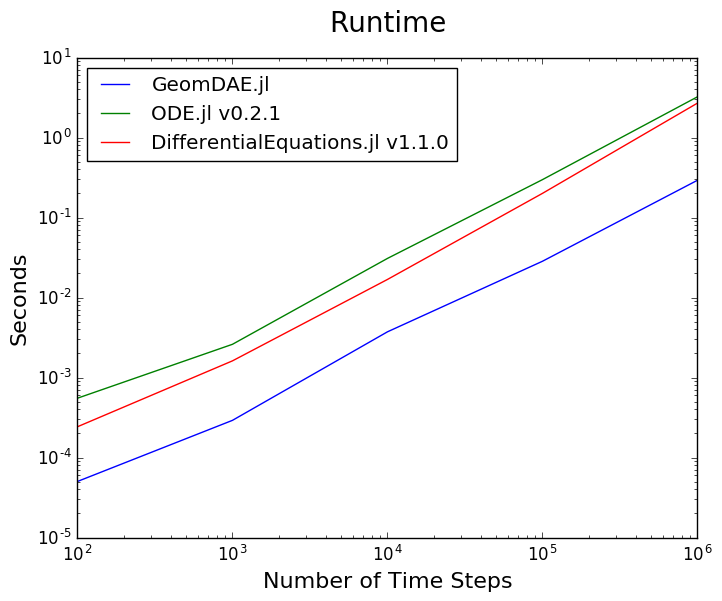

In [24]:
fig = figure(figsize=(8,6))
loglog(ntimes, geomdae_tel, label="GeomDAE.jl")
loglog(ntimes, ode_tel,     label="ODE.jl v0.2.1")
loglog(ntimes, de_tel,      label="DifferentialEquations.jl v1.1.0")
title("Runtime", y=1.04, fontsize=20)
xlabel("Number of Time Steps", fontsize=16)
ylabel("Seconds", fontsize=16)
legend(loc="upper left")
savefig("pendulum_runtime.pdf")

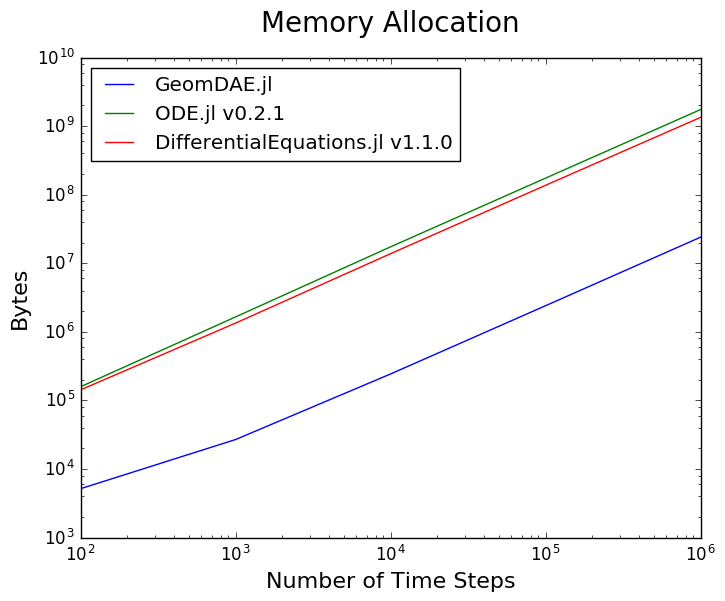

In [25]:
fig = figure(figsize=(8,6))
loglog(ntimes, geomdae_mem, label="GeomDAE.jl")
loglog(ntimes, ode_mem,     label="ODE.jl v0.2.1")
loglog(ntimes, de_mem,      label="DifferentialEquations.jl v1.1.0")
title("Memory Allocation", y=1.04, fontsize=20)
xlabel("Number of Time Steps", fontsize=16)
ylabel("Bytes", fontsize=16)
legend(loc="upper left")
savefig("pendulum_memory_allocation.pdf")